# Flower Feature Localization with Grad-CAM

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import random
from random import shuffle 
import collections
import io
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras 

In [2]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## Data Preparation

In [3]:
FLOWERS_DIR ='dataset/Annotated-FlowerData-30'
# FLOWERS_DIR ='/content/drive/Shareddrives/Visual Information Processing/FlowerData-30'

In [4]:
H, W = 224, 224
BATCH_SIZE = 64
EPOCHS = 100

TRAIN_FRACTION = 80
RANDOM_SEED = 2018

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

Found 1982 images belonging to 30 classes.
Found 491 images belonging to 30 classes.


In [6]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 30))

In [7]:
print(train_generator.class_indices)

{'Artichoke': 0, 'Azalea': 1, 'Bearded Iris': 2, 'Bird of Paradise': 3, 'Bluebell': 4, 'Bromelia': 5, 'Buttecup': 6, 'Camellia': 7, 'Canna Lily': 8, 'Colts_Foot': 9, 'Columbine': 10, 'Cowslip': 11, 'Crocus': 12, 'Daffodil': 13, 'Daisy': 14, 'Dandelion': 15, 'Fritillary': 16, 'LilyValley': 17, 'Mexican Petunia': 18, 'Pansy': 19, 'Peruvian Lily': 20, 'Poinsettia': 21, 'Purple Coneflower': 22, 'Snapdragon': 23, 'Snowdrop': 24, 'Sunflower': 25, 'Sweet William': 26, 'Tigerlily': 27, 'Tulip': 28, 'Windflower': 29}


In [8]:
# saving labels to txt file
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)
    
print('done!')

done!


In [9]:
save_path = 'labels.txt'
label = np.array(open(save_path).read().splitlines())

## MobileNetV2, ResNet50 and InceptionV3

We trained 3 types of convolutional neural networks, which are MobileNetV2, ResNet50 and InceptionV3. The training process for all three networks are available in separate Jupyter notebooks.

MobileNetV2: `FL-MobileNetV2.ipynb`  
ResNet50: `FL-ResNet50.ipynb`  
InceptionV3: `FL-InceptionV3.ipynb`

### Loading the Pre-Trained Models

We have a total of 3 CNN models - MobileNetV2, ResNet50 and InceptionV3

In [10]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
mobilenet = tf.keras.models.load_model(
    'model/MobileNetV2.h5', 
    custom_objects={
        "precision_m": precision, 
        "recall_m": recall
    }
)

resnet = tf.keras.models.load_model(
    'model/ResNet50.h5', 
    custom_objects={
        "precision_m": precision, 
        "recall_m": recall
    }
)

inception = tf.keras.models.load_model(
    'model/InceptionV3.h5', 
    custom_objects={
        "precision_m": precision, 
        "recall_m": recall
    }
)

### Interpreting the Results

In [19]:
# Function to load image
def load_image(img_path, show=False, title=None):

    img = image.load_img(img_path, target_size=(H, W))
    img_tensor = image.img_to_array(img) # (height, width, channels)
            
    # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)dat
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    
    img_tensor /= 255. # imshow expects values in the range [0, 1]
    plt.title(title)
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

# Function to show top x predicitons of the model
def pred_result(pred, show_top=3):
    
    top_results = np.argsort(pred[0])[-show_top:][::-1]
    prediction = []
    
    for i in top_results:
        prediction.append([label[i], "{:.5f}".format(pred[0][i])])
    
    df = pd.DataFrame(prediction, columns = ['flower', 'probability'])
    display(df)

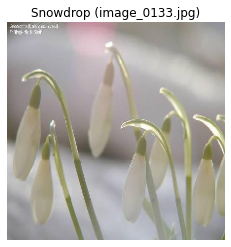


===== MobileNetV2 =====


,flower,probability
0,Snowdrop,0.99999
1,Fritillary,0.00001
2,LilyValley,0.00000



====== ResNet50 =======


,flower,probability
0,Buttecup,0.09333
1,Sunflower,0.08345
2,Bearded Iris,0.07374



===== InceptionV3 =====


,flower,probability
0,Snowdrop,0.99745
1,Crocus,0.00093
2,Fritillary,0.00078


In [24]:
# load a random image from our dataset
random_flower = random.choice(os.listdir(FLOWERS_DIR))
random_image = random.choice(os.listdir(FLOWERS_DIR+'/'+random_flower))
image_path = FLOWERS_DIR+'/'+random_flower+'/'+random_image

title = f'{random_flower} ({random_image})'
flower_image = load_image(image_path, show=True, title=title)
#print('img:', random_image)


print('\n===== MobileNetV2 =====')
pred_m = mobilenet.predict(flower_image)
pred_result(pred_m, show_top=3)

print('\n====== ResNet50 =======')
pred_r = resnet.predict(flower_image)
pred_result(pred_r, show_top=3)

print('\n===== InceptionV3 =====')
pred_i = inception.predict(flower_image)
pred_result(pred_i, show_top=3)

## Grad-CAM

In [ ]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
                model.output])
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
        # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
        
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb